In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [54]:
from  sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df=pd.read_csv("output.csv")
df.head()

,time,city,income,state,product,_id,temp,surge,weather
0,"Fri, 20 Nov 2015 22:19:52 GMT",Atlanta,High,GA,UberSUV,b605b0b06730c256bc90499b6c53afaf,62,10,Clear
1,"Wed, 18 Nov 2015 17:54:37 GMT",Atlanta,Low,GA,UberBLACK,06acbfc4f40ff6cb6ef15a8755945079,66,10,Rain
2,"Wed, 18 Nov 2015 19:27:14 GMT",Atlanta,High,GA,UberBLACK,8a45a65827191fa1ba23fdf767196104,69,10,Rain
3,"Wed, 18 Nov 2015 23:12:56 GMT",Boston,Middle,MA,UberBLACK,f19996613c10c3bf40289591e13b9734,40,10,Partly Cloudy
4,"Sat, 21 Nov 2015 02:21:21 GMT",Washington,Low,DC,uberX,f5fd3879435d240acb5bbbe808caf81b,48,10,Clear


In [98]:
# Function to put full name of Day
def day_fix(string):
    if string == 'Mon':
        return "Monday"
    elif string =='Tue':
        return "Tuesday"
    elif string =='Wed':
        return "Wednesday"
    elif string =='Thu':
        return 'Thursday'
    elif string == 'Fri':
        return 'Friday'
    elif string == 'Sat':
        return 'Saturday'
    elif string == 'Sun':
        return 'Sunday'
    else:
        print "Error in day_fix!!!!!"

# Function to round everything **Down** to the nearest 10 minutes
def min_fix(string):
    num = int(string)
    return str(num - (num%10))

# Check and replace the surge
def surge_check(surge):
    if surge == 10:
        return "No Surge"
    elif surge > 15:
        return "High Surge"
    elif surge == 15:
        return "Mid Surge"
    else:
        return "Low Surge"

After messing with the data, found that only a small percentage of the data has a Surge (only 5.6%). After digging deeper into the surge prices and messing around with different combinations I set the limits at **Low Surge < 1.5x**, **Mid Surge = 1.5x**, and **High Surge > 1.5x**. I thought that is a fair cut off as well because you are spending 50% more on the ride at 1.5x surge.

In [119]:
# Code to extract Weekdays and time of day from given dataframe
time_list = [df.time[index].split(' ') for index in df.index]
weekday_list = []
hour_list = []
for row in range(len(time_list)):
    time_list[row].remove('GMT')
    time_list[row][0] = time_list[row][0].replace(',','')
    time_list[row][0] = day_fix(time_list[row][0])
    weekday_list.append(time_list[row][0])
    hour_list.append(time_list[row][4][0:2] + ':' + min_fix(time_list[row][4][3:5]) )


In [120]:
#Code to create Surge levels
surge_list = [surge_check(df.surge[index]) for index in df.index]

In [121]:
#Code to convert Temp to ints
temperature_list = [int(df.temp[index]) for index in df.index]

In [122]:
#Code to clean cartype
for index in df.index:
    if df.loc[index,'product'] == 'uberX + Car Seat':
        df.loc[index,'product'] = 'uberX'
    elif df.loc[index,'product'] == 'SUV + Car Seat':
        df.loc[index,'product'] = 'UberSUV'
    elif df.loc[index,'product'] == 'BLACK CAR + Car Seat':
        df.loc[index,'product'] = 'UberBlack'
    elif df.loc[index,'product'] == 'UberSELECT':
        df.loc[index,'product'] = 'uberSELECT'
    
    

In [123]:
# Create Final Dataframe for use
dict_final = {'id': df._id, 'surge': surge_list , 'temperature': temperature_list, 'weather': df.weather,
             'cartype': df['product'], 'city': df.city, 'income': df.income, 'weekday': weekday_list, 
              'time': hour_list}
df_final = pd.DataFrame(dict_final)
df_final.head()

,cartype,city,id,income,surge,temperature,time,weather,weekday
0,UberSUV,Atlanta,b605b0b06730c256bc90499b6c53afaf,High,No Surge,62,22:10,Clear,Friday
1,UberBLACK,Atlanta,06acbfc4f40ff6cb6ef15a8755945079,Low,No Surge,66,17:50,Rain,Wednesday
2,UberBLACK,Atlanta,8a45a65827191fa1ba23fdf767196104,High,No Surge,69,19:20,Rain,Wednesday
3,UberBLACK,Boston,f19996613c10c3bf40289591e13b9734,Middle,No Surge,40,23:10,Partly Cloudy,Wednesday
4,uberX,Washington,f5fd3879435d240acb5bbbe808caf81b,Low,No Surge,48,02:20,Clear,Saturday


In [124]:
# Code to test No Surge vs Low Surge vs. High Surge

count_nosurge = df['surge'] == 10
count_surge = df['surge'] != 10
surgedf = df[count_surge]

count_highsurge = df['surge'] > 15
count_lowsurge = surgedf['surge'] < 15
count_midsurge = surgedf['surge'] == 15

print 'Percentage of data that has surge %0.3f' % (float(sum(count_surge))/len(df_final))
print 'Percentage of Surge that has Low Surge %0.3f' % (float(sum(count_lowsurge))/sum(count_surge))
print 'Percentage of Surge that has High Surge %0.3f' % ((float(sum(count_highsurge))/sum(count_surge)))
print 'Percentage of Surge that has Mid Surge %0.3f' % (float(sum(count_midsurge))/sum(count_surge))


Percentage of data that has surge 0.056
Percentage of Surge that has Low Surge 0.370
Percentage of Surge that has High Surge 0.291
Percentage of Surge that has Mid Surge 0.339


In [125]:
# split into training and test data
itrain, itest = train_test_split(xrange(df_final.shape[0]), train_size=0.7)

mask=np.ones(df_final.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

#split training set into validation set if needed (not ended up needed)
itrain, itest = train_test_split(xrange(df_final[mask].shape[0]), train_size=0.7)

mask2 = np.ones(df_final[mask].shape[0], dtype = 'int')
mask2[itrain] = 1
mask2[itest] = 0
mask2 = (mask2==1)


In [126]:
#Check data cleaning
print df_final['weather'].unique()
print df_final['cartype'].unique()
print df_final['city'].unique()
print len(df_final['time'].unique())
print type(df_final['temperature'][0])

['Clear' 'Rain' 'Partly Cloudy' 'Overcast' 'Mostly Cloudy'
 'Scattered Clouds' 'Light Rain']
['UberSUV' 'UberBLACK' 'uberX' 'uberXL' 'uberWAV' 'uberTAXI' 'uberSELECT'
 'WAV' 'uberFAMILY' 'uberT' 'UberBlack' 'ASSIST' 'Yellow WAV']
['Atlanta' 'Boston' 'Washington' 'New York' 'San Francisco']
142
<type 'numpy.int64'>


In [127]:
#Create the X matrix
Xvec_list = []
for i in range(len(df)):
    temp_dict = {}
    temp_dict['city'] = dict_final['city'][i]
    temp_dict['cartype'] = dict_final['cartype'][i]
    temp_dict['income'] = dict_final['income'][i]
    temp_dict['temperature'] = dict_final['temperature'][i]
    temp_dict['time'] = dict_final['time'][i]
    temp_dict['weather'] = dict_final['weather'][i]
    temp_dict['weekday'] = dict_final['weekday'][i]
    Xvec_list.append(temp_dict)

vec = DictVectorizer()
vec.fit_transform(Xvec_list)
fcolumns = vec.get_feature_names()
data = vec.fit_transform(Xvec_list).toarray()
X_final = pd.DataFrame(data = data, columns = fcolumns)
X_final.head()

,cartype=ASSIST,cartype=UberBLACK,cartype=UberBlack,cartype=UberSUV,cartype=WAV,cartype=Yellow WAV,cartype=uberFAMILY,cartype=uberSELECT,cartype=uberT,cartype=uberTAXI,cartype=uberWAV,cartype=uberX,cartype=uberXL,city=Atlanta,city=Boston,city=New York,city=San Francisco,city=Washington,income=High,income=Low,income=Middle,temperature,time=00:0,time=00:10,time=00:20,time=00:30,time=00:40,time=00:50,time=01:0,time=01:10,time=01:20,time=01:30,time=01:40,time=01:50,time=02:0,time=02:10,time=02:20,time=02:30,time=02:40,time=02:50,time=03:0,time=03:10,time=03:20,time=03:30,time=03:40,time=03:50,time=04:0,time=04:10,time=04:20,time=04:30,...,time=17:40,time=17:50,time=18:0,time=18:10,time=18:20,time=18:30,time=18:40,time=18:50,time=19:0,time=19:10,time=19:20,time=19:30,time=19:40,time=19:50,time=20:0,time=20:10,time=20:20,time=20:30,time=20:40,time=20:50,time=21:0,time=21:10,time=21:20,time=21:30,time=21:40,time=21:50,time=22:0,time=22:10,time=22:20,time=22:30,time=22:40,time=22:50,time=23:0,time=23:10,time=23:20,time=23:30,time=23:40,time=23:50,weather=Clear,weather=Light Rain,weather=Mostly Cloudy,weather=Overcast,weather=Partly Cloudy,weather=Rain,weather=Scattered Clouds,weekday=Friday,weekday=Saturday,weekday=Thursday,weekday=Tuesday,weekday=Wednesday
0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [128]:
#Create the Y matrix
Yvec_list = []
for i in range(len(df)):
    temp_dict = {}
    temp_dict['surge'] = dict_final['surge'][i]
    Yvec_list.append(temp_dict)

vec2 = DictVectorizer()
vec2.fit_transform(Yvec_list)
columns = vec2.get_feature_names()
data = vec2.fit_transform(Yvec_list).toarray()
Y_final = pd.DataFrame(data = data, columns = columns)
Y_final.head()

,surge=High Surge,surge=Low Surge,surge=Mid Surge,surge=No Surge
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [129]:
#Train and test sets
X = X_final[mask]
Y = Y_final[mask]
X_train = X[mask2]
Y_train = Y[mask2]
X_Val = X[~mask2]
Y_Val = Y[~mask2]
X_test = X_final[~mask]
Y_test = Y_final[~mask]

In [131]:
# Use cv_optimize writen in hw3
def cv_optimize(clf, parameters, X, y, n_folds= 5, score_func= None):
    clftemp = GridSearchCV(clf, parameters, cv = n_folds, score_func=score_func )
    clftemp.fit(X, y)
    best = clftemp.best_estimator_
    params = clftemp.best_params_
    print best
    return best, params

In [132]:
#parameter dictionary to be passed into cv_optimize
parameters_dict = {}
parameters_dict['max_features'] = ['auto', 'sqrt', 'log2', None]
parameters_dict['class_weight'] = ['auto', 'subsample']
parameters_dict['max_depth'] = [None]

In [133]:
#optimize the best predictor for random forest
%%time
rf = RandomForestClassifier(oob_score = True)
rf2, rf2params = cv_optimize(rf,parameters_dict, X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight='subsample',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)
Wall time: 3min 55s


In [141]:
#best predictor
rf2 = RandomForestClassifier(class_weight = rf2params['class_weight'],
                             max_depth = rf2params['max_depth'], max_features = rf2params['max_features'])
rf2params

{'class_weight': 'subsample', 'max_depth': None, 'max_features': 'sqrt'}

In [142]:
#See how prediction evolves over the amount of trees in random forest
#note: will always increase with more trees, but reaches a "limit" where it just takes forever to train the model,
#so pick a place where this is optimal by a time prespective

num_trees = range(10,110,10)
scores = []
for i in range(len(num_trees)):
    rf2 = RandomForestClassifier(n_estimators = num_trees[i],
                                 class_weight = rf2params['class_weight'], 
                                 max_depth = rf2params['max_depth'])
    rf2.fit(X,Y)
    scores.append(rf2.score(X_test,Y_test))

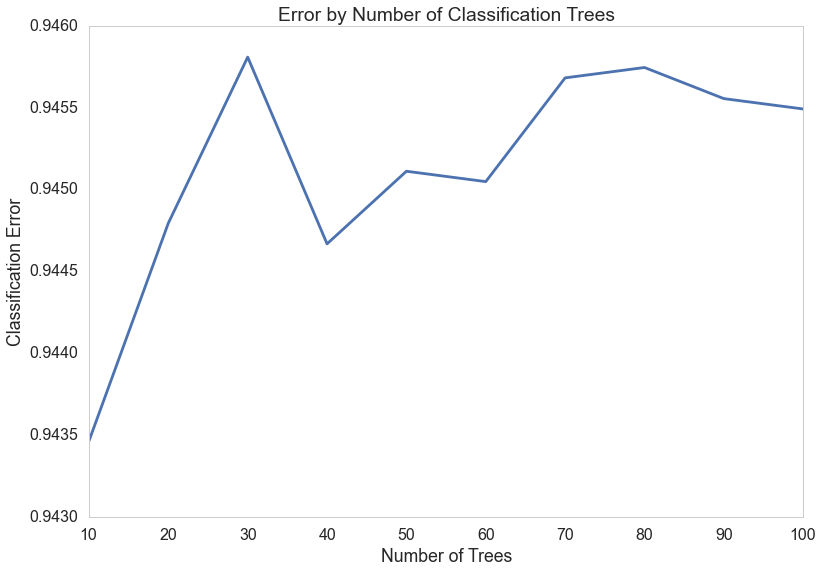

In [178]:
#show plot of error and number of trees in classifier
plt.plot(scores)
plt.xticks(np.arange(10),num_trees)
plt.ylabel('Classification Error')
plt.xlabel('Number of Trees')
plt.title('Error by Number of Classification Trees')
plt.grid('off')
plt.show()

In [144]:
#check the score on the test set for overfitting
rf2 = RandomForestClassifier(n_estimators = 90,
                             class_weight = rf2params['class_weight'], 
                             max_depth = rf2params['max_depth'])
rf2.fit(X,Y)
print rf2.score(X_test,Y_test)
print rf2.score(X,Y)

0.945236737022
0.976392284705


0.13244613959440943

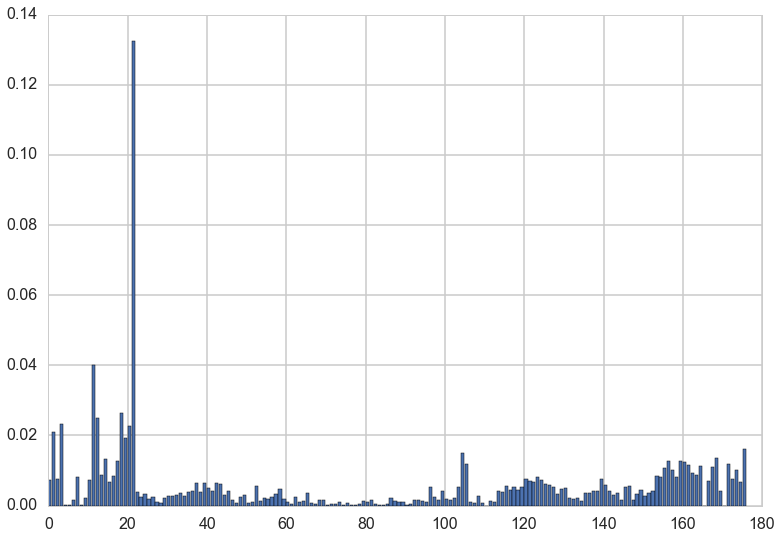

In [145]:
#plot the feature importances
features = rf2.feature_importances_
plt.bar(np.arange(len(features)),features)
max(features)

In [201]:
rf2.predict_proba(X_test)

[array([[ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        ..., 
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.]]), array([[ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        ..., 
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.]]), array([[ 0.98888889,  0.01111111],
        [ 0.95555556,  0.04444444],
        [ 1.        ,  0.        ],
        ..., 
        [ 1.        ,  0.        ],
        [ 1.        ,  0.        ],
        [ 1.        ,  0.        ]]), array([[ 0.01111111,  0.98888889],
        [ 0.04444444,  0.95555556],
        [ 0.        ,  1.        ],
        ..., 
        [ 0.        ,  1.        ],
        [ 0.        ,  1.        ],
        [ 0.        ,  1.        ]])]

In [146]:
#Temperature seems to be the best predictor at this point
print features[21]
print fcolumns[21]
print features[12]
print fcolumns[160]

0.132446139594
temperature
0.0249602013453
time=23:20


In [158]:
# Fix the Y variable for Logistic Regression
df_final['surge'].head()
Y_lreg = df_final['surge'][mask]
Y_lregtest = df_final['surge'][~mask]
Y_lreg.head()

0    No Surge
2    No Surge
3    No Surge
4    No Surge
5    No Surge
Name: surge, dtype: object

In [169]:
#parameters to be tested for Logistic Regression
lreg_paramdict = {}
lreg_paramdict['C'] = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
lreg_paramdict['penalty'] = ['l1','l2']
lreg_paramdict['multi_class'] = ['multinomial']
lreg_paramdict['class_weight'] = ['auto',None]

In [171]:
# optimize parameters for logistic regression
%%time
lreg = LogisticRegression(solver ='lbfgs' )
lreg2, lregparams = cv_optimize(lreg,lreg_paramdict, X, Y_lreg)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          penalty='l1', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0)
Wall time: 6min 10s


In [176]:
lreg2 = LogisticRegression(solver ='lbfgs', C = lregparams['C'], class_weight = lregparams['class_weight'],
                           multi_class = lregparams['multi_class'], penalty = lregparams['penalty'] )
lreg2.fit(X,Y_lreg)
print lreg2.score(X,Y_lreg)
print lreg2.score(X_test,Y_lregtest)

0.943520782396
0.943905685492


In [203]:
lreg2.predict_proba(X_test)

array([[ 0.06512861,  0.07213785,  0.26785431,  0.59487922],
       [ 0.10195074,  0.25118669,  0.13596034,  0.51090223],
       [ 0.06151384,  0.18257045,  0.16600788,  0.58990784],
       ..., 
       [ 0.08125689,  0.19223633,  0.17188388,  0.55462289],
       [ 0.094474  ,  0.14031953,  0.17538646,  0.58982001],
       [ 0.03528186,  0.14078205,  0.12769427,  0.69624182]])

In [212]:
lreg2.coef_[3][21]

0.017789825312028107

In [55]:
help(LogisticRegression)

Help on class LogisticRegression in module sklearn.linear_model.logistic:

class LogisticRegression(sklearn.base.BaseEstimator, sklearn.linear_model.base.LinearClassifierMixin, sklearn.feature_selection.from_model._LearntSelectorMixin, sklearn.linear_model.base.SparseCoefMixin)
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr' and uses the
 |  cross-entropy loss, if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs' and
 |  'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  `liblinear` library, newton-cg and lbfgs solvers. It can handle both
 |  dense and sparse input. Use C-ordered arrays or CSR matrices containing
 |  64-bit floats for optimal performance; any other input format will be
 |  converted (and copied).
 |  
 |  T

In [56]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble.forest:

class RandomForestClassifier(ForestClassifier)
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and use averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  
 |  Parameters
 |  ----------
 |  n_estimators : integer, optional (default=10)
 |      The number of trees in the forest.
 |  
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |      Note: this parameter is tree-specific.
 |  
 |  max_features : int, float, string or None, optional (default="auto")
 |      The number of features to consider when looking for the best split:
 |  
 |      - If int, then consider `max_features` features at each split.
 |      - If f